#Importación de librerías necesarias

In [113]:
# Cargar libreriras y modulos
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.linear_model import LogisticRegression                            # Para usar modelos de regresion logistica
from sklearn.tree import DecisionTreeClassifier                                # Para usar modelos de tipo arboles de decision
from sklearn.neighbors import KNeighborsClassifier                             # Para modelos  Knn
from sklearn.svm import SVC                                                    # Para modelos SVM

from sklearn.model_selection import train_test_split                           # Para partir los datos en conjuntos de entrenamiento y validacion
from sklearn.model_selection import KFold                                      # Para partir la data en k-folds
from sklearn.model_selection import cross_val_score                            # Para evaluar algoritmos en cross validacion

from sklearn.metrics import accuracy_score, balanced_accuracy_score            # Para manejar metricas de desempeño
from sklearn.metrics import classification_report                              # Para hacer reportes de resultados de clasificacion
from sklearn.metrics import confusion_matrix                                   # Para manejar matrices de confusion

from sklearn.preprocessing import StandardScaler, MinMaxScaler                 # Para escalar los columnas de los datos antes de procesar
from sklearn.pipeline import make_pipeline                                     # Para construir pipelines

#Revisión de la data

In [114]:
# carga el dataset pima-indians-diabetes
dataset = pd.read_csv('/content/data_BC.csv', delimiter = ';')
dataset.head()

,Diagnosis,radius1,texture1,perimeter1,area1,smoothness1,compactness1,concavity1,concave_points1,symmetry1,...,radius3,texture3,perimeter3,area3,smoothness3,compactness3,concavity3,concave_points3,symmetry3,fractal_dimension3
0,M,15.46,19.48,101.70,748.9,0.10920,0.12230,0.14660,0.08087,0.1931,...,19.26,26.00,124.90,1156.0,0.15460,0.2394,0.3791,0.15140,0.2837,0.08019
1,B,12.89,13.12,81.89,515.9,0.06955,0.03729,0.02260,0.01171,0.1337,...,13.62,15.54,87.40,577.0,0.09616,0.1147,0.1186,0.05366,0.2309,0.06915
2,B,14.96,19.10,97.03,687.3,0.08992,0.09823,0.05940,0.04819,0.1879,...,16.25,26.19,109.10,809.8,0.13130,0.3030,0.1804,0.14890,0.2962,0.08472
3,B,12.94,16.17,83.18,507.6,0.09879,0.08836,0.03296,0.02390,0.1735,...,13.86,23.02,89.69,580.9,0.11720,0.1958,0.1810,0.08388,0.3297,0.07834
4,M,13.17,18.66,85.98,534.6,0.11580,0.12310,0.12260,0.07340,0.2128,...,15.67,27.95,102.80,759.4,0.17860,0.4166,0.5006,0.20880,0.3900,0.11790


In [115]:
dataset['Diagnosis'].value_counts()    # Esta es la variable a predecir

,count
Diagnosis,
B,357
M,212


#Definición de funciones necesarias

In [116]:
# Extrae la data y la divide en entrada y salida
def Extrae_datos(dt):

  arr = dt.values
  x_ = arr[:,1:len(dt.columns)-1]   # atributos
  y_ = arr[:,0]                     # target

  return x_, y_

In [117]:
# Evalua cada algoritmo de ML
def Compara_accuracy_de_modelos_10Folds(list_alg, x_trn, y_trn):

  # Evaluaremos cada algoritmo de ML en estrategia de 10-fold-CV
  kfold = KFold(n_splits=10, random_state=seed, shuffle= True)  # Especifica el particionador de datos a 10-folds CV

  # Mostrar accuracies
  results = []
  names = []
  for algo_name, algo in list_alg:
    cv_results = cross_val_score(algo, x_trn, y_trn, cv=kfold, scoring='balanced_accuracy')
    results.append(cv_results)
    names.append(algo_name)
    print("{}: {} ({})".format(algo_name, cv_results.mean(), cv_results.std()))

  # Comparar distribución de accuracies para cada uno de los modelos ML
  fig = plt.figure()
  fig.suptitle('balanced_accuracy  obtenidas en 10-fold-CV')
  ax = fig.add_subplot(111)
  plt.boxplot(results)
  ax.set_xticklabels(names)
  plt.show()

In [118]:
# Genera una predicción con el modelo seleccionado
def Predecir_con_modelo(algo, x_trn, y_trn, x_vld):

  model = algo
  model.fit(x_trn, y_trn)
  y_prd = model.predict(x_vld)

  return y_prd


# Evalúa la predicción con las salidas predichas y reales
def Mostrar_evaluacion_de_prediccion(y_vld, y_prd):

  print("Puntaje del Balanced Accuracy:", balanced_accuracy_score(y_vld, y_prd))    # predice la clase del conjunto de validacion

  print("\nMatriz de Confusión:")
  print(confusion_matrix(y_vld, y_prd))                                       # muestra la matriz de confusion

  print("\nReporte de clasificacion en conjunto de validacion: \n")
  print(classification_report(y_vld, y_prd))                                  # muestra un reporte de la clasificacion en validacion

#Inicialización de la data y Kfolds

In [119]:
X, y = Extrae_datos(dataset)

## Se realiza el train-test split
vadid_fraction = 0.20    # 20% para validación
seed = 7                 # Semilla para el generador aleatorio (para reproductibilidad)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=vadid_fraction, random_state=seed)

print(f'> Tamaño del training: {len(y_train)}')
print(f'> Tamaño del Validation: {len(y_valid)}')

> Tamaño del training: 455
> Tamaño del Validation: 114


#Comparamos el rendimiento de cada algoritmo ML

In [120]:
# Definimos una lista de algoritmos de ML a evaluar
alg = []
alg.append(('LogReg', LogisticRegression( solver='liblinear')))     # Genera logistic regresors con solver liblinear
alg.append(('5NN', KNeighborsClassifier( n_neighbors=5)))           # Genera knn con 5 vecinos
alg.append(('10NN', KNeighborsClassifier( n_neighbors=10)))         # Genera knn con 10 vecinos
alg.append(('CART', DecisionTreeClassifier(max_depth=None )))       # Genera DT sin restriccion de profundidad
alg.append(('SVC', SVC( )))                                         # Genera SVC con kernel radial (por default)

LogReg: 0.9436365722998445 (0.03201184936822373)
5NN: 0.9235975841898487 (0.027582872491426928)
10NN: 0.9178115924509708 (0.034865187227894154)
CART: 0.941442958118327 (0.02955063784227631)
SVC: 0.892996446652319 (0.04067395838616037)


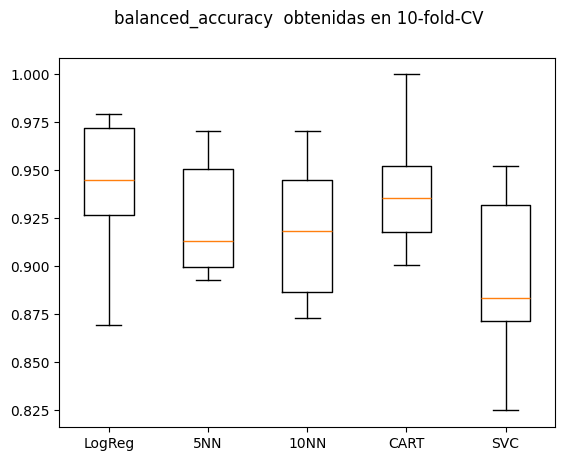

In [121]:
Compara_accuracy_de_modelos_10Folds(alg, X_train, y_train)

**Comentarios:**

Se logra observar que los algoritmos propuestos no tienen mucha diferencia entre sí en cuanto su precisión. Además, todos tienen buen rendimiento, pero no en su totalidad.

Se realizará una predicción con la regresión logística para ver sus resultados.

###Evaluamos predicción del mejor algoritmo ML

In [122]:
y_predicted = Predecir_con_modelo(LogisticRegression(solver='liblinear', class_weight = 'balanced'), X_train, y_train, X_valid)

Mostrar_evaluacion_de_prediccion(y_valid, y_predicted)

Puntaje del Balanced Accuracy: 0.9407894736842105

Matriz de Confusión:
[[71  5]
 [ 2 36]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           B       0.97      0.93      0.95        76
           M       0.88      0.95      0.91        38

    accuracy                           0.94       114
   macro avg       0.93      0.94      0.93       114
weighted avg       0.94      0.94      0.94       114



**Comentarios:**

Se predijo con considerable precisión, en especial la clase "B", sin embargo se intentará usar pipelines con escaladores para lograr un mejor resultado

#Comparamos el rendimiento de cada pipeline (MinMaxScaler + algoritmo ML)

In [123]:
# Definimos el pool de pipleines de ML a evaluar
pipelines = []
pipelines.append(('LogReg', make_pipeline(MinMaxScaler(),LogisticRegression(solver='liblinear'))))
pipelines.append(('5NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=5))))
pipelines.append(('10NN', make_pipeline(MinMaxScaler(), KNeighborsClassifier(n_neighbors=10))))
pipelines.append(('CART', make_pipeline(MinMaxScaler(), DecisionTreeClassifier(max_depth=None))))
pipelines.append(('SVC', make_pipeline(MinMaxScaler(), SVC())))

LogReg: 0.9542314974715355 (0.04236505768419787)
5NN: 0.960429350061703 (0.0306147938587849)
10NN: 0.959660633484163 (0.034831921776638915)
CART: 0.9199722780297599 (0.04051420717596322)
SVC: 0.9709188787177403 (0.025355108084677693)


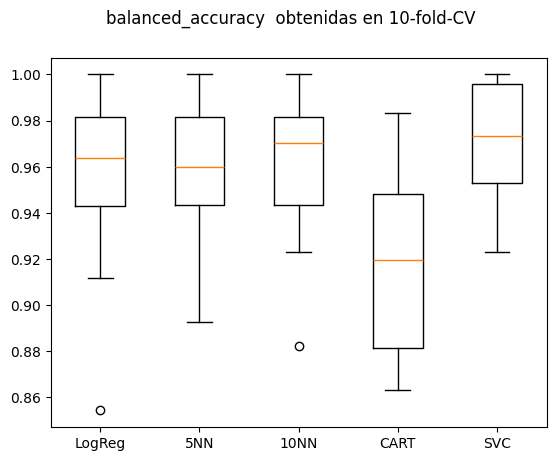

In [124]:
Compara_accuracy_de_modelos_10Folds(pipelines, X_train, y_train)

**Comentarios:**

Utilizando el pipeline se obtienen mejores resultados. En especial con el SVC que previamente era el de menor rendmiento

###Evaluamos predicción del mejor pipeline

SVC (Kernel polinímico): 0.9597087511260337 (0.029809605528340423)
SVC (Kernel rbf): 0.9709188787177403 (0.025355108084677693)


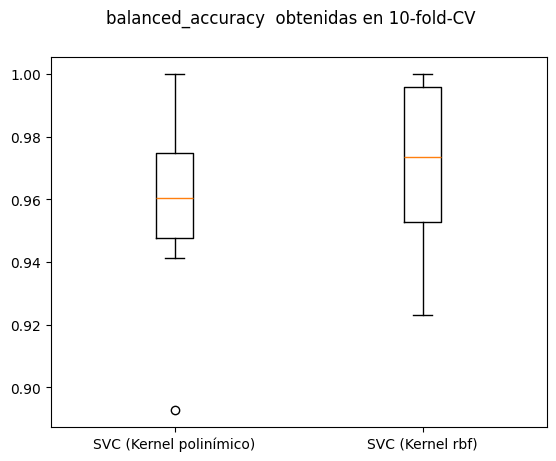

In [125]:
Compara_accuracy_de_modelos_10Folds([('SVC (Kernel polinímico)', make_pipeline(MinMaxScaler(), SVC(kernel = 'poly'))), ('SVC (Kernel rbf)', make_pipeline(MinMaxScaler(), SVC(kernel = 'rbf')))], X_train, y_train)

**Comentarios**

Se hizo una comparación entre el SVC con diferentes parámetros, de lo cual para esta aplicación resultó mejor usando Kernel rbf

In [126]:
y_predicted_ppl = Predecir_con_modelo(make_pipeline(MinMaxScaler(), SVC(kernel = 'rbf')), X_train, y_train, X_valid)

Mostrar_evaluacion_de_prediccion(y_valid, y_predicted_ppl)

Puntaje del Balanced Accuracy: 0.9605263157894737

Matriz de Confusión:
[[74  2]
 [ 2 36]]

Reporte de clasificacion en conjunto de validacion: 

              precision    recall  f1-score   support

           B       0.97      0.97      0.97        76
           M       0.95      0.95      0.95        38

    accuracy                           0.96       114
   macro avg       0.96      0.96      0.96       114
weighted avg       0.96      0.96      0.96       114

